In [75]:
import numpy as np
import pandas as pd
import os 
import sys
import torch

DATASETS = '../datasets/'

def read_file(dir_name):
    main_df = pd.DataFrame()
    directory = DATASETS + dir_name
    for filename in os.listdir(directory):
        data = np.load(os.path.join(directory, filename))
        data_dict = {}
        for keys in data.keys():
            data_dict[keys] = list(data[keys])
        df = pd.DataFrame.from_dict(data_dict)
        main_df = pd.concat([main_df, df])
    return main_df

In [76]:
data = []
for name in os.listdir("../datasets/mw"):
    inner_df = pd.DataFrame()
    if not (name.startswith('.')):
        dir_name = 'mw/'+name
        print(dir_name)
        df = read_file(dir_name)
        inner_df = pd.concat([inner_df, df])    
    data.append(inner_df)
data = np.array(data, dtype=object)


mw/cls_sweep-v2
mw/cls_push-v2
mw/cls_door-open-v2
mw/cls_peg-insert-side-v2
mw/cls_drawer-close-v2
mw/cls_basketball-v2
mw/cls_reach-v2
mw/cls_window-open-v2
mw/cls_pick-place-v2
mw/cls_button_press_topdown-v2


# MAIN CODE

In [90]:
import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import tqdm
import warnings
import copy
import matplotlib.pyplot as plt
import random
import math
from torch.nn import functional as F
warnings.filterwarnings('ignore')


class MetaRewardMLPEnsemble(nn.Module):
    def __init__(
        self,
        hidden_layers=[256, 256, 256],
        act=F.leaky_relu,
        output_act=torch.tanh,
    ):
        super().__init__()
        params = {}
        last_dim = 39 + 4
        self.num_layers = len(hidden_layers) + 1
        for i, dim in enumerate(
            hidden_layers
            + [
                1,
            ]
        ):
            weight = torch.empty(last_dim, dim)
            weight.transpose_(0, 1)
            nn.init.kaiming_uniform_(weight, a=math.sqrt(5))
            weight.transpose_(0, 1)
            params[f"linear_w_{i}"] = nn.Parameter(weight)
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(params[f"linear_w_{i}"].T)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            params[f"linear_b_{i}"] = nn.Parameter(
                nn.init.uniform_(torch.empty(1, dim, requires_grad=True), -bound, bound)
            )
            last_dim = dim

        self.params = nn.ParameterDict(params)
        self.parameters = self.params.parameters 
        self.act = act
        self.output_act = output_act

    def forward(self, x, params=None):
        if params is None:
            params = self.params
        # x = torch.cat((obs, action), dim=1)
        # x = x.repeat(self.ensemble_size, 1, 1)
        for i in range(self.num_layers):
            x = params[f"linear_b_{i}"] + torch.matmul( x, params[f"linear_w_{i}"] )
            if i == self.num_layers - 1:
                x = self.output_act(x)
            else:
                x = self.act(x)
        return x.squeeze(-1)
    
    

class Reptile:
    def __init__(
        self,
        ml10,
        input_size,
        hidden_size1,
        hidden_size2,
        hidden_size3,
        outer_lr = 1e-7,
        inner_lr = 0.001,
        num_support=10,
        num_query=10,
        num_inner_steps=5,
        k = 25,
        num_tasks = 10,
        episode_per_task = 1250,
        output_size = 2750,
        beta1 = 0.9, 
        beta2 = 0.999,
        adam_alpha = 0.001,
        adam_eps = 1e-8,
        **kwargs,
    ):
        self.ml10 = ml10
        self.reward_criterion =  nn.BCELoss()
        self.num_support = num_support
        self.num_query = num_query
        self.num_inner_steps = num_inner_steps
        self.inner_lr = inner_lr
        self.outer_lr = outer_lr
        self.k = k
        self.num_tasks = num_tasks
        self.episode_per_task = episode_per_task
        self.num_segments = None
        self.model = MetaRewardMLPEnsemble()
        self.beta1 = beta1
        self.beta2 = beta2
        self.adam_alpha = adam_alpha
        self.adam_eps = adam_eps
        self.m_dict = {k: torch.zeros_like(v) for k, v in self.model.params.items()}
        self.v_dict = {k: torch.zeros_like(v) for k, v in self.model.params.items()}
        self._lrs = torch.nn.ParameterDict(
            {
                k: torch.nn.Parameter(torch.tensor(self.inner_lr), requires_grad=True)
                for k, v in self.model.params.items()
            }
        )
        self.optim = optim.Adam(itertools.chain(self.model.params.values(), self._lrs.values()), lr=0.0001)


    def construct_episodes(self, ml10):
        # episodes - n (tasks) x num_episode (each npz file)  , each cell is a dataframe of the episode 
        self.episodes = []
        for task in ml10:
            if(len(task)==0):
                continue
            task_episodes=[]
            row_index = task[task['done'] == True].index.tolist()
            prev=0
            for x in row_index:
                task_episodes.append(task[prev:x+1])
                prev=x+1
            task_episodes = np.array(task_episodes,dtype=object)
            self.episodes.append(task_episodes)
        self.episodes = np.array(self.episodes,dtype=object)
        # return episodes

    def form_sigma_groups(self, episode):
        #num_segments = int(episode.shape[0] / self.k)
        split_indices = np.arange(self.k, episode.shape[0], self.k)
        # print(num_segments)
        if len(split_indices) != 0:
            l_segment = np.array_split(episode.iloc[::-1][:(self.k*(episode.shape[0] // self.k))], split_indices)
            for i in range(len(l_segment)):
                l_segment[i] = l_segment[i].iloc[::-1]
            if(len(l_segment[-1])<25):
                l_segment=l_segment[:-1]
            return l_segment
        else:
            return None

    def compare_probabilities(self, sigma1, sigma2):
        exp_sum_rewards_sigma1 = np.exp(sum(row['reward'] for row in sigma1))
        exp_sum_rewards_sigma2 = np.exp(sum(row['reward'] for row in sigma2))
        prob = exp_sum_rewards_sigma1 / (exp_sum_rewards_sigma1 + exp_sum_rewards_sigma2)
        return [0] if prob > 0.5 else [1]

    def prepare_data(self):
        X = []
        y = []
        episodes = self.episodes
        # sigmas = self.form_sigma_groups(episodes, k)
        sigmas = []
        for task in episodes:
            sigma = []
            for episode in task:
                segment = self.form_sigma_groups(episode)
                # print(len(segment))
                if segment is not None:
                    sigma.append(segment)
            # sigma = [self.form_sigma_groups(episode, k) for episode in task]
            sigmas.append(sigma)
        sigmas = np.array(sigmas, dtype=object)
        all_lengths = [len(episode) for task in sigmas for episode in task]
        self.num_segments = min(all_lengths)
        if(self.num_segments<3):
            self.num_segments=3
        for task in sigmas:
            task_list=[]
            for episode in task:
                ep_list=[]
                if(len(episode)<self.num_segments):
                    continue
                for i in range(self.num_segments):
                    y.append(episode[i]["reward"])
                    ep_list.append(episode[i].drop('reward', axis=1))
                task_list.append(ep_list)
            task_list=np.array(task_list, dtype=object).reshape(-1,1) # convert row vector to col vector
            X.append(task_list)
        X_new=[]
        task_counter = []
        for task in X:
            counter = 0
            for i in range(0,len(task),4):
                X_new.append(np.concatenate((task[i][0], task[i+1][0])))
                counter += 1
            task_counter.append(counter)
        X = np.array(X_new, dtype=object)
        task_counts = np.array(task_counter, dtype=object)
        y=np.array(y,dtype=object)
        y=y.flatten()
        return X, y, task_counts
    
    def batchify(self, X, y, task_lengths, task_no, num=110):
        # print(task_no)
        if task_no == 0:
            task_beg = 0  
            task_end = task_lengths[0]
        else:    
            task_beg = np.sum(task_lengths[0:task_no])    
            task_end = np.sum(task_lengths[0:task_no+1])
        rand = random.sample(range(0,400), 110)
        X_task = X[task_beg:task_end]
        y_task = y[task_beg:task_end]
        X_random = []
        y_random = []
        for r in rand:
            X_random.append(X_task[r*25 : r*25+25])
            y_random.append(y_task[r*25 : r*25+25])
        X_random = np.array(X_random, dtype=np.float32)
        y_random = np.array(y_random, dtype=np.float32)
        return X_random.reshape(2750,43), y_random.reshape(2750,)


    def train(self, X, y, task_lengths, num_epochs):
        plt_x = np.arange(0, num_epochs)
        plt_y = np.zeros(num_epochs)

        for epoch in tqdm(range(num_epochs)):
            # self.optim.zero_grad()
            current_weights = self.model.params
            # print('\n\nParams new epoch:\n', current_weights['linear_w_1'])

            loss, neg_grad = self._outer_step(self.model, X, y, task_lengths, epoch, num_epochs)  ## negative of weights is essentially the gradient

            # print('\n\nWeights (-grad):\n', weights)
            
            print(f'Epoch: {epoch} - Loss: {loss}')
            if loss is None:
                return {}
            
            # \theta = \theta + \alpha * (\phi - \theta)
            alpha = 0.0001 #* (1 - epoch / num_epochs) # \alpha = outer_lr * (1 - epoch / num_outer_epochs)
            state_dict = {candidate: (current_weights[candidate] + alpha * neg_grad[candidate])  ## - current_weights[candidate] 
                          for candidate in neg_grad}

            idx = 0
            for name, w in self.model.params.items():
                if name in ['linear_b_0', 'linear_b_1', 'linear_b_2', 'linear_b_3']:
                    self.model.params[name] = state_dict[name]
                else:   
                    self.model.params[name] = state_dict[name]
                idx += 1

            # print('\n\nParams after update:\n', self.model.params['linear_w_1'])


            plt_y[epoch] = loss
        
            if epoch % 10 == 0:
                plt.plot(plt_x[:epoch+1], plt_y[:epoch+1])
                plt.xlabel("Epochs")
                plt.ylabel("Mean Loss")
                plt.show() 
                # print(f"Epoch: {epoch}, Loss: {plt_y[epoch]}")
                
            # loss.backward()
            # self.optim.step()


    def _outer_step(self, model, X, y, task_lengths, epoch, num_epochs):
        phi = model.params 
        outer_losses = []
        for t in range(self.num_tasks):
            X_b, y_b = self.batchify(X, y, task_lengths, t)
            H, W = X_b.shape
            inner_x = X_b[:H//2, :]
            inner_y = y_b[:H//2]
            outer_x = X_b[H//2:, :]
            outer_y = y_b[H//2:]

            weights = self._inner_loop(inner_x, inner_y, model = model)
            # weights = self._inner_loop(X_b, y_b, model = model)
            # print('\n\nWeights from Outer:\n', weights)

            outer_losses.append(self._compute_loss(outer_x, outer_y, model, parameters=weights))
            # outer_losses.append(self._compute_loss(X_b, y_b, model, parameters=weights))

            # # \theta = \theta + \alpha * (\phi - \theta)
            # alpha = 0.0001 * (1 - epoch / num_epochs) # \alpha = outer_lr * (1 - epoch / num_outer_epochs)
            if t==0:
                sum_W_minus_phi = {candidate: ((weights[candidate] - phi[candidate])/0.001) for candidate in weights}
                # print(sum_W_minus_phi)
            else:
                sum_W_minus_phi = {candidate: (sum_W_minus_phi[candidate] + (weights[candidate] - phi[candidate])/0.001) for candidate in weights}

            # idx = 0
            # for name, w in model.params.items():
            #     if name in ['linear_b_0', 'linear_b_1', 'linear_b_2', 'linear_b_3']:
            #         model.params[name] = state_dict[name]
            #     else:   
            #         model.params[name] = state_dict[name]
            #     idx += 1


            # print(outer_losses)
        if (len(outer_losses) == 0):
            return None
        outer_loss = torch.mean(torch.stack(outer_losses))
        # print("Outer Loss: ", outer_loss)

        return outer_loss, sum_W_minus_phi


            
    def _inner_loop(self, X, y, model):
        params_og = model.params
        new_dict = {k: torch.clone(v) for k, v in params_og.items()} ######### state_dict

        for inner_ep in range(5):

            loss = self._compute_loss(X, y, model, parameters = new_dict)
            grad = torch.autograd.grad(loss, new_dict.values(), create_graph=True)
            # print(grad)

            idx = 0
            for name, w in params_og.items():
                if name in ['linear_b_0', 'linear_b_1', 'linear_b_2', 'linear_b_3']:
                    new_dict[name] = new_dict[name] - 0.001 * grad[idx]
                else:
                    new_dict[name] = new_dict[name] - 0.001 * grad[idx]
                idx += 1

        return new_dict

    '''
    R_E = 
    [
        [
            sigma_s1^E1, ..., sigma_s#^E1
        ],
        [
            sigma_s1^E2, ..., sigma_s#^E2
        ], ...,
        [
            sigma_s1^EN, ..., sigma_s#^EN
        ]
    ]
    '''
    #self.k = segment lenght
    def _compute_loss(self, X, y, model, parameters = None):
        X_tensor = torch.from_numpy(X)
        y_tensor = torch.from_numpy(y)
        if parameters is not None:
            output_reward = model.forward(X_tensor, parameters) # WORKING
        else:
            print('Params are NONE')
            output_reward = model(X_tensor)
        # N_o, _ = output_reward.shape
        # print(output_reward.shape)
        x =  y_tensor.shape[0]
        N = x//self.k
        output_reward = output_reward.reshape(N, self.k)
        output_reward = torch.sum(output_reward, dim=1)
        y_tensor = y_tensor.reshape(N, self.k)
        y_tensor = torch.sum(y_tensor, dim=1)
        loss = 0
        criterion = nn.BCEWithLogitsLoss()
        loss = []
        for i in range(N):
            for j in range(i+1, N):
                if y_tensor[i] > y_tensor[j]:
                    loss.append(criterion(output_reward[j] - output_reward[i], torch.tensor(0.0, requires_grad= True)))
                else:
                    loss.append(criterion(output_reward[j] - output_reward[i], torch.tensor(1.0, requires_grad= True)))

        loss = torch.mean(torch.stack(loss)) #### sum

        return loss

################################################################################################
################################################################################################
################################################################################################

ml10 = data.copy()  
input_size = 43  # Assuming obs has 39 numbers and action has 4 numbers * 2 for pair of sigmas
hidden_size1 = 256
hidden_size2 = 256
hidden_size3 = 256
# hidden_size3 = 1024
# hidden_size4 = 2075

output_size = 1
num_epochs = 5
outer_lr = 0.0001

model = Reptile(ml10, input_size, hidden_size1, hidden_size2, hidden_size3)

model.construct_episodes(ml10)
print('Preparing Data.')



Preparing Data.


In [78]:
X, y, task_lengths = model.prepare_data()
print('Data Preparation Done.\n')

Data Preparation Done.



  0%|                                                 | 0/10000 [00:00<?, ?it/s]

Epoch: 0 - Loss: 0.6510623097419739


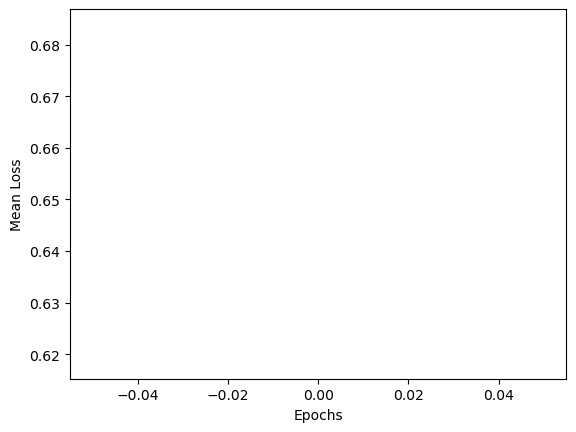

  0%|                                      | 1/10000 [00:06<19:10:10,  6.90s/it]

Epoch: 1 - Loss: 0.6270379424095154


  0%|                                      | 2/10000 [00:16<23:30:59,  8.47s/it]

Epoch: 2 - Loss: 0.6369662880897522


  0%|                                      | 3/10000 [00:26<24:55:04,  8.97s/it]

Epoch: 3 - Loss: 0.6321372985839844


  0%|                                      | 4/10000 [00:35<25:35:40,  9.22s/it]

Epoch: 4 - Loss: 0.6372864842414856


  0%|                                      | 5/10000 [00:44<25:42:37,  9.26s/it]

Epoch: 5 - Loss: 0.6253032684326172


  0%|                                      | 6/10000 [00:54<26:01:51,  9.38s/it]

Epoch: 6 - Loss: 0.6434764266014099


  0%|                                      | 7/10000 [01:03<25:56:03,  9.34s/it]

Epoch: 7 - Loss: 0.6238964200019836


  0%|                                      | 8/10000 [01:13<26:06:07,  9.40s/it]

Epoch: 8 - Loss: 0.607632577419281


  0%|                                      | 9/10000 [01:22<25:49:25,  9.30s/it]

Epoch: 9 - Loss: 0.6361140012741089


  0%|                                     | 10/10000 [01:32<26:03:24,  9.39s/it]

Epoch: 10 - Loss: 0.6100489497184753


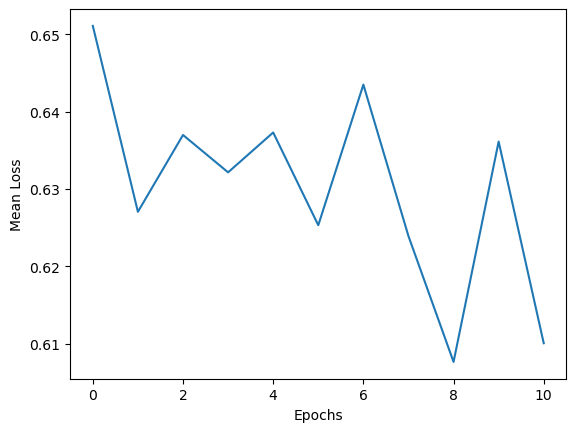

  0%|                                     | 11/10000 [01:41<26:04:26,  9.40s/it]

Epoch: 11 - Loss: 0.617408037185669


  0%|                                     | 12/10000 [01:51<26:30:25,  9.55s/it]

Epoch: 12 - Loss: 0.611596941947937


  0%|                                     | 13/10000 [02:02<27:47:59, 10.02s/it]

Epoch: 13 - Loss: 0.6161485910415649


  0%|                                     | 14/10000 [02:12<28:00:45, 10.10s/it]

Epoch: 14 - Loss: 0.6274721026420593


  0%|                                     | 15/10000 [02:22<27:48:05, 10.02s/it]

Epoch: 15 - Loss: 0.643038272857666


  0%|                                     | 16/10000 [02:32<27:44:33, 10.00s/it]

Epoch: 16 - Loss: 0.6098145246505737


  0%|                                     | 17/10000 [02:42<27:59:35, 10.09s/it]

Epoch: 17 - Loss: 0.6349651217460632


  0%|                                     | 18/10000 [02:53<28:24:16, 10.24s/it]

Epoch: 18 - Loss: 0.6134541630744934


  0%|                                     | 19/10000 [03:04<28:57:37, 10.45s/it]

Epoch: 19 - Loss: 0.602777898311615


  0%|                                     | 20/10000 [03:13<28:04:23, 10.13s/it]

Epoch: 20 - Loss: 0.6108752489089966


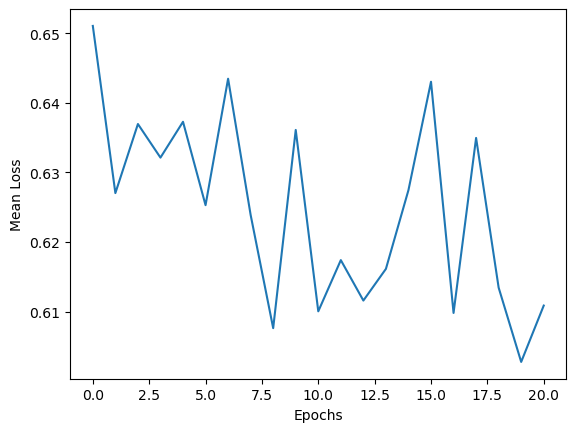

  0%|                                     | 21/10000 [03:23<27:45:43, 10.02s/it]

Epoch: 21 - Loss: 0.6105045080184937


  0%|                                     | 22/10000 [03:32<27:13:00,  9.82s/it]

Epoch: 22 - Loss: 0.6054010987281799


  0%|                                     | 23/10000 [03:42<27:21:38,  9.87s/it]

Epoch: 23 - Loss: 0.615329921245575


  0%|                                     | 24/10000 [03:52<27:20:24,  9.87s/it]

Epoch: 24 - Loss: 0.6054134368896484


  0%|                                     | 25/10000 [04:01<26:49:36,  9.68s/it]

Epoch: 25 - Loss: 0.62418532371521


  0%|                                     | 26/10000 [04:11<26:44:00,  9.65s/it]

Epoch: 26 - Loss: 0.6173922419548035


  0%|                                     | 27/10000 [04:21<26:51:11,  9.69s/it]

Epoch: 27 - Loss: 0.6175945401191711


  0%|                                     | 28/10000 [04:31<27:01:11,  9.75s/it]

Epoch: 28 - Loss: 0.5968469977378845


  0%|                                     | 29/10000 [04:40<26:51:27,  9.70s/it]

Epoch: 29 - Loss: 0.610141396522522


  0%|                                     | 30/10000 [04:50<26:44:09,  9.65s/it]

Epoch: 30 - Loss: 0.606368899345398


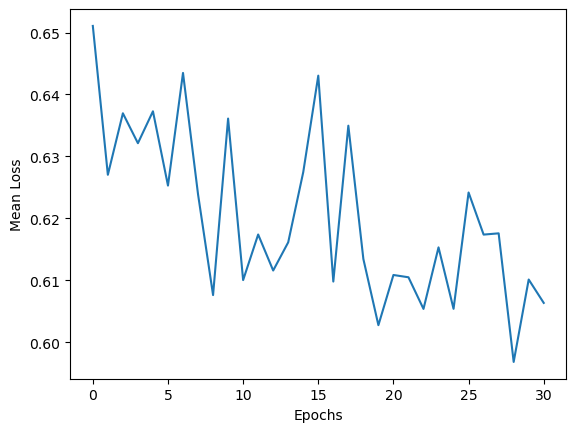

  0%|                                     | 31/10000 [04:59<26:36:48,  9.61s/it]

Epoch: 31 - Loss: 0.6066071391105652


  0%|                                     | 32/10000 [05:09<26:47:04,  9.67s/it]

Epoch: 32 - Loss: 0.6126849055290222


  0%|                                     | 33/10000 [05:19<26:53:46,  9.71s/it]

Epoch: 33 - Loss: 0.6168128252029419


  0%|▏                                    | 34/10000 [05:29<26:57:37,  9.74s/it]

Epoch: 34 - Loss: 0.6076492071151733


  0%|▏                                    | 35/10000 [05:38<26:39:06,  9.63s/it]

Epoch: 35 - Loss: 0.6178537607192993


  0%|▏                                    | 36/10000 [05:48<26:44:01,  9.66s/it]

Epoch: 36 - Loss: 0.6036478281021118


  0%|▏                                    | 37/10000 [05:58<26:44:30,  9.66s/it]

Epoch: 37 - Loss: 0.5992778539657593


  0%|▏                                    | 38/10000 [06:08<27:07:06,  9.80s/it]

Epoch: 38 - Loss: 0.5905932784080505


  0%|▏                                    | 39/10000 [06:17<26:42:05,  9.65s/it]

Epoch: 39 - Loss: 0.5843437314033508


  0%|▏                                    | 40/10000 [06:27<26:38:11,  9.63s/it]

Epoch: 40 - Loss: 0.5974351763725281


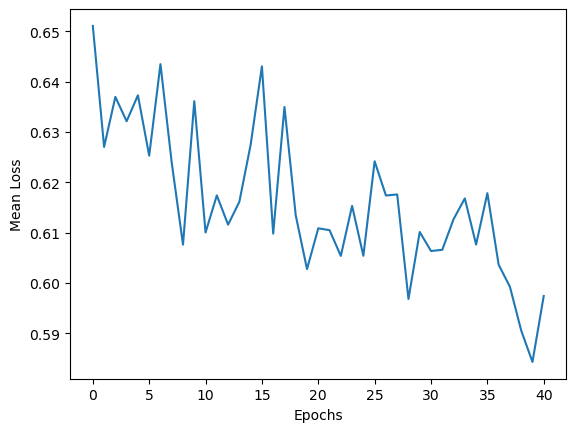

  0%|▏                                    | 41/10000 [06:36<26:33:33,  9.60s/it]

Epoch: 41 - Loss: 0.6147106885910034


  0%|▏                                    | 42/10000 [06:46<26:48:23,  9.69s/it]

Epoch: 42 - Loss: 0.5982983112335205


  0%|▏                                    | 43/10000 [06:56<26:40:19,  9.64s/it]

Epoch: 43 - Loss: 0.598406195640564


  0%|▏                                    | 44/10000 [07:05<26:29:24,  9.58s/it]

Epoch: 44 - Loss: 0.6056752800941467


  0%|▏                                    | 45/10000 [07:15<26:27:53,  9.57s/it]

Epoch: 45 - Loss: 0.616808295249939


  0%|▏                                    | 46/10000 [07:24<26:15:36,  9.50s/it]

Epoch: 46 - Loss: 0.6019827127456665


  0%|▏                                    | 47/10000 [07:34<26:25:30,  9.56s/it]

Epoch: 47 - Loss: 0.6154356002807617


  0%|▏                                    | 48/10000 [07:43<26:01:54,  9.42s/it]

Epoch: 48 - Loss: 0.602117657661438


  0%|▏                                    | 49/10000 [07:53<26:27:40,  9.57s/it]

Epoch: 49 - Loss: 0.5942234396934509


  0%|▏                                    | 50/10000 [08:02<26:20:53,  9.53s/it]

Epoch: 50 - Loss: 0.603249192237854


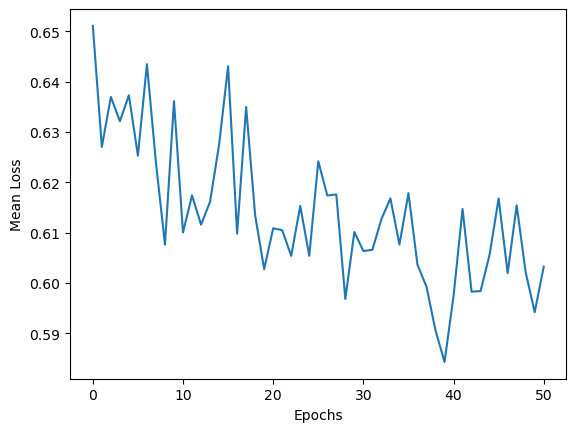

  1%|▏                                    | 51/10000 [08:12<26:36:26,  9.63s/it]

Epoch: 51 - Loss: 0.6166237592697144


  1%|▏                                    | 52/10000 [08:22<26:54:10,  9.74s/it]

Epoch: 52 - Loss: 0.6049559116363525


  1%|▏                                    | 53/10000 [08:32<27:00:25,  9.77s/it]

Epoch: 53 - Loss: 0.6261383295059204


  1%|▏                                    | 54/10000 [08:41<27:01:01,  9.78s/it]

Epoch: 54 - Loss: 0.6113262176513672


  1%|▏                                    | 55/10000 [08:51<26:36:14,  9.63s/it]

Epoch: 55 - Loss: 0.6021115183830261


  1%|▏                                    | 56/10000 [09:00<26:30:48,  9.60s/it]

Epoch: 56 - Loss: 0.5889849066734314


  1%|▏                                    | 57/10000 [09:10<26:35:52,  9.63s/it]

Epoch: 57 - Loss: 0.5887922048568726


  1%|▏                                    | 58/10000 [09:19<26:13:15,  9.49s/it]

Epoch: 58 - Loss: 0.5925412178039551


  1%|▏                                    | 59/10000 [09:29<26:41:08,  9.66s/it]

Epoch: 59 - Loss: 0.5993369817733765


  1%|▏                                    | 60/10000 [09:39<26:34:56,  9.63s/it]

Epoch: 60 - Loss: 0.5945315957069397


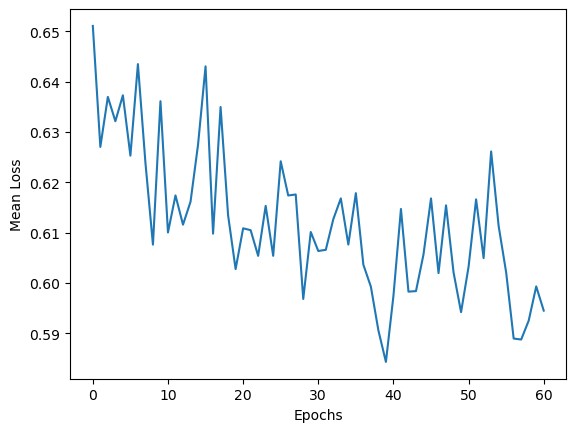

  1%|▏                                    | 61/10000 [09:49<26:40:34,  9.66s/it]

Epoch: 61 - Loss: 0.5988091826438904


  1%|▏                                    | 62/10000 [09:58<26:39:06,  9.65s/it]

Epoch: 62 - Loss: 0.6021748781204224


  1%|▏                                    | 63/10000 [10:08<26:35:35,  9.63s/it]

Epoch: 63 - Loss: 0.612811267375946


  1%|▏                                    | 64/10000 [10:17<26:20:11,  9.54s/it]

Epoch: 64 - Loss: 0.580759584903717


  1%|▏                                    | 65/10000 [10:27<26:16:36,  9.52s/it]

Epoch: 65 - Loss: 0.589300811290741


  1%|▏                                    | 66/10000 [10:38<28:13:54, 10.23s/it]

Epoch: 66 - Loss: 0.5813373327255249


  1%|▏                                    | 67/10000 [10:49<28:13:31, 10.23s/it]

Epoch: 67 - Loss: 0.5933322906494141


  1%|▎                                    | 68/10000 [11:00<29:10:05, 10.57s/it]

Epoch: 68 - Loss: 0.5908475518226624


  1%|▎                                    | 69/10000 [11:10<28:41:52, 10.40s/it]

Epoch: 69 - Loss: 0.6077871918678284


  1%|▎                                    | 70/10000 [11:19<27:40:12, 10.03s/it]

Epoch: 70 - Loss: 0.5984565615653992


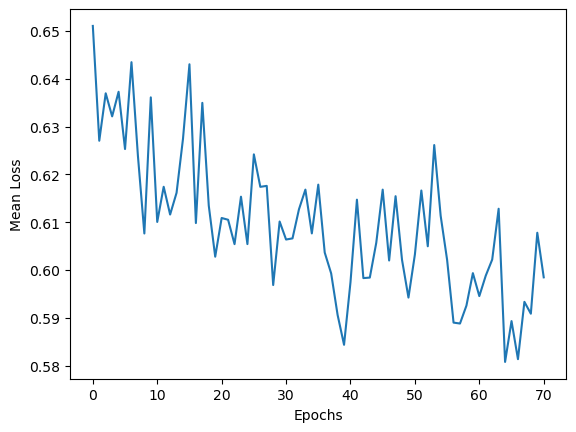

  1%|▎                                    | 71/10000 [11:29<27:31:23,  9.98s/it]

Epoch: 71 - Loss: 0.6083859205245972


  1%|▎                                    | 72/10000 [11:39<27:17:30,  9.90s/it]

Epoch: 72 - Loss: 0.5983372926712036


  1%|▎                                    | 73/10000 [11:49<27:12:44,  9.87s/it]

Epoch: 73 - Loss: 0.583807110786438


  1%|▎                                    | 74/10000 [11:58<26:56:27,  9.77s/it]

Epoch: 74 - Loss: 0.5881523489952087


  1%|▎                                    | 75/10000 [12:08<27:09:20,  9.85s/it]

Epoch: 75 - Loss: 0.5895109176635742


  1%|▎                                    | 76/10000 [12:17<26:43:46,  9.70s/it]

Epoch: 76 - Loss: 0.5784025192260742


  1%|▎                                    | 77/10000 [12:27<26:32:29,  9.63s/it]

Epoch: 77 - Loss: 0.6063207983970642


  1%|▎                                    | 78/10000 [12:37<27:00:19,  9.80s/it]

Epoch: 78 - Loss: 0.5759483575820923


  1%|▎                                    | 79/10000 [12:47<26:52:48,  9.75s/it]

Epoch: 79 - Loss: 0.5846849679946899


  1%|▎                                    | 80/10000 [12:56<26:31:10,  9.62s/it]

Epoch: 80 - Loss: 0.5957826375961304


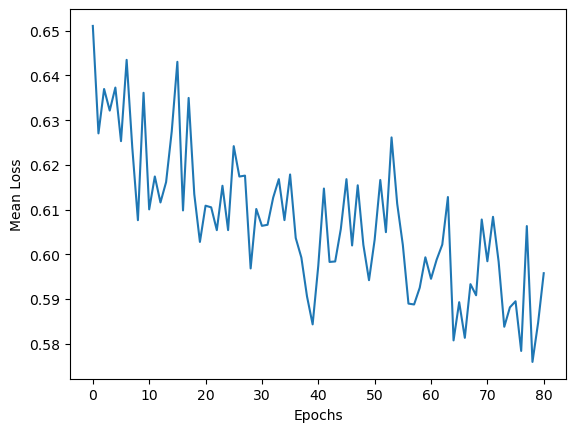

  1%|▎                                    | 81/10000 [13:06<26:31:23,  9.63s/it]

Epoch: 81 - Loss: 0.5938031077384949


  1%|▎                                    | 82/10000 [13:16<26:45:51,  9.71s/it]

Epoch: 82 - Loss: 0.5914632081985474


  1%|▎                                    | 83/10000 [13:25<26:36:56,  9.66s/it]

Epoch: 83 - Loss: 0.5811408162117004


  1%|▎                                    | 84/10000 [13:34<26:16:45,  9.54s/it]

Epoch: 84 - Loss: 0.565880537033081


  1%|▎                                    | 85/10000 [13:44<26:26:25,  9.60s/it]

Epoch: 85 - Loss: 0.5835827589035034


  1%|▎                                    | 86/10000 [13:54<26:17:03,  9.54s/it]

Epoch: 86 - Loss: 0.5966188311576843


  1%|▎                                    | 87/10000 [14:03<25:55:38,  9.42s/it]

Epoch: 87 - Loss: 0.5954667329788208


  1%|▎                                    | 88/10000 [14:13<26:12:41,  9.52s/it]

Epoch: 88 - Loss: 0.5883723497390747


  1%|▎                                    | 89/10000 [14:22<26:00:36,  9.45s/it]

Epoch: 89 - Loss: 0.5732520222663879


  1%|▎                                    | 90/10000 [14:32<26:36:27,  9.67s/it]

Epoch: 90 - Loss: 0.5927945375442505


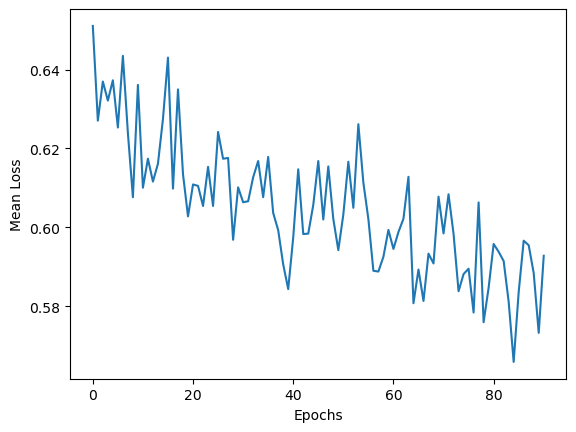

  1%|▎                                    | 91/10000 [14:41<26:23:14,  9.59s/it]

Epoch: 91 - Loss: 0.584561824798584


  1%|▎                                    | 92/10000 [14:52<27:10:16,  9.87s/it]

Epoch: 92 - Loss: 0.5859875679016113


  1%|▎                                    | 93/10000 [15:02<27:05:55,  9.85s/it]

Epoch: 93 - Loss: 0.5811651349067688


  1%|▎                                    | 94/10000 [15:11<26:32:03,  9.64s/it]

Epoch: 94 - Loss: 0.6087333559989929


  1%|▎                                    | 95/10000 [15:20<26:13:05,  9.53s/it]

Epoch: 95 - Loss: 0.6026909947395325


  1%|▎                                    | 96/10000 [15:30<26:12:17,  9.53s/it]

Epoch: 96 - Loss: 0.5753370523452759


  1%|▎                                    | 97/10000 [15:39<26:05:15,  9.48s/it]

Epoch: 97 - Loss: 0.5651034116744995


  1%|▎                                    | 98/10000 [15:49<26:25:29,  9.61s/it]

Epoch: 98 - Loss: 0.5757738351821899


  1%|▎                                    | 99/10000 [15:58<26:03:32,  9.48s/it]

Epoch: 99 - Loss: 0.5887311100959778


  1%|▎                                   | 100/10000 [16:09<26:54:17,  9.78s/it]

Epoch: 100 - Loss: 0.5923449397087097


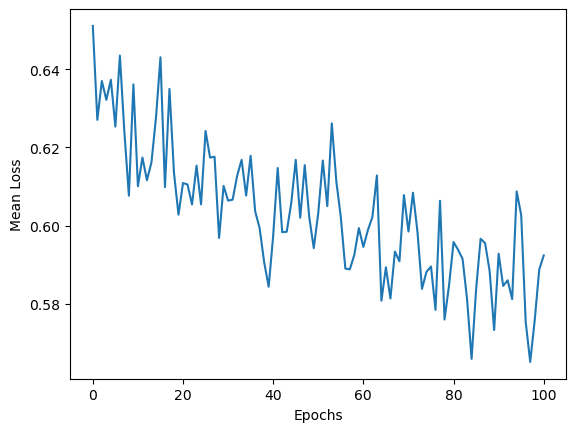

  1%|▎                                   | 101/10000 [16:18<26:35:19,  9.67s/it]

Epoch: 101 - Loss: 0.5914407968521118


  1%|▎                                   | 102/10000 [16:28<26:45:24,  9.73s/it]

Epoch: 102 - Loss: 0.604393482208252


  1%|▎                                   | 103/10000 [16:37<26:31:19,  9.65s/it]

Epoch: 103 - Loss: 0.578628420829773


  1%|▎                                   | 104/10000 [16:47<26:27:30,  9.63s/it]

Epoch: 104 - Loss: 0.5581589937210083


  1%|▍                                   | 105/10000 [16:56<26:03:24,  9.48s/it]

Epoch: 105 - Loss: 0.6004992723464966


  1%|▍                                   | 106/10000 [17:06<26:26:27,  9.62s/it]

Epoch: 106 - Loss: 0.5980232954025269


  1%|▍                                   | 107/10000 [17:17<27:23:19,  9.97s/it]

Epoch: 107 - Loss: 0.5786854028701782


  1%|▍                                   | 108/10000 [17:27<27:56:32, 10.17s/it]

Epoch: 108 - Loss: 0.585925817489624


  1%|▍                                   | 109/10000 [17:37<27:09:13,  9.88s/it]

Epoch: 109 - Loss: 0.564942479133606


  1%|▍                                   | 110/10000 [17:46<26:53:23,  9.79s/it]

Epoch: 110 - Loss: 0.5724271535873413


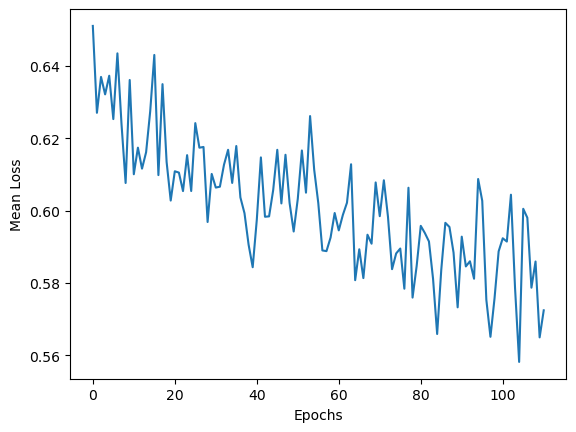

  1%|▍                                   | 111/10000 [17:56<27:14:57,  9.92s/it]

Epoch: 111 - Loss: 0.5903167128562927


  1%|▍                                   | 112/10000 [18:06<27:00:26,  9.83s/it]

Epoch: 112 - Loss: 0.5710915923118591


  1%|▍                                   | 113/10000 [18:16<27:21:22,  9.96s/it]

In [91]:
model.train(X, y, task_lengths, 10000)

In [ ]:
test = pd.DataFrame()
for name in os.listdir("../datasets/mw_valid"):
    if not (name.startswith('.')):
        dir_name = 'mw_valid/'+name
        print(dir_name)
        df = read_file(dir_name)
        test = pd.concat([data, df])

test.reset_index(drop=True, inplace=True)
Test = PreferenceMAML(test, input_size, hidden_size1, hidden_size2, output_size)
test_X, test_y = Test.prepare_data(k=4)


# Evaluate the model on the test set
def evaluate_model(model, X, y):
    predictions = []
    with torch.no_grad():
        for i in range(len(X)):
            X_tensor = torch.tensor(X[i], dtype=torch.float32)
            output = model.model(X_tensor.unsqueeze(0))  
            predictions.append(output.squeeze().numpy())  

    preds = []
    for _ in range(len(predictions)):
        preds.append((np.array(predictions[_]).mean()))

    pred_label = []
    for i in range(len(preds)):
        pred_label.append([0] if preds[i]>0.5 else [1])
    
    sum = 0
    for _ in range(len(y)):
        sum += pred_label[_]==y[_]
    accuracy = sum/len(y)
    return accuracy, pred_label

test_accuracy, pred_labels = evaluate_model(model, test_X, test_y)
print(f'\nTest Accuracy: {test_accuracy}')

### Without INNER LOOP

In [ ]:
# import itertools
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import pandas as pd

# class Model(nn.Module):
#     def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
#         super(Model, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.fc3 = nn.Linear(hidden_size2, output_size)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.sigmoid(self.fc3(x))
#         return x


# class PreferenceMAML:
#     def __init__(
#         self,
#         ml10,
#         input_size,
#         hidden_size1,
#         hidden_size2,
#         output_size,
#         num_support=10,
#         num_query=10,
#         num_inner_steps=5,
#         **kwargs,
#     ):
#         self.ml10 = ml10
#         self.reward_criterion =  nn.CrossEntropyLoss()
#         self.num_support = num_support
#         self.num_query = num_query
#         self.num_inner_steps = num_inner_steps

#         self.model = Model(input_size, hidden_size1, hidden_size2, output_size)

#     def construct_episodes(self):
#         episodes = []
#         episode = []
#         for _, row in self.ml10.iterrows():
#             episode.append(row)
#             if row['done']:
#                 episodes.append(episode)
#                 episode = []
#         return episodes



#     def form_sigma_groups(self, episode, k):
#         sigmas = []
#         segments = []
#         q, r = divmod(len(episode), k)
#         for i in range(k):
#             segments.append(episode[i*q+min(i,r) : (i+1)*q+min(i+1,r)])

#         for i in range(k):
#             sigma_i = segments[i]
#             for j in range(i+1, k):
#                 sigma_j = segments[j]

#                 sigmas.append((sigma_i, sigma_j))
#         return sigmas

#     def compare_probabilities(self, sigma1, sigma2):
#         exp_sum_rewards_sigma1 = np.exp(sum(row['reward'] for row in sigma1))
#         exp_sum_rewards_sigma2 = np.exp(sum(row['reward'] for row in sigma2))
#         prob = exp_sum_rewards_sigma1 / (exp_sum_rewards_sigma1 + exp_sum_rewards_sigma2)
#         return [1,0] if prob > 0.5 else [0,1]


#     def prepare_data(self, k):
#         X = []
#         y = []
#         episodes = self.construct_episodes()
#         for episode in episodes:
#             sigmas = self.form_sigma_groups(episode, k)
#             for _ in range(len(sigmas)):

#                 sigma1 = sigmas[_][0]
#                 sigma2 = sigmas[_][1]

#                 obs_action_sigma1 = []
#                 for row in sigma1:
#                     obs_action = list(row['obs']) + list(row['action'])  # Concatenate obs and action
#                     obs_action_sigma1.append(obs_action)

#                 obs_action_sigma2 = []
#                 for row in sigma2:
#                     obs_action = list(row['obs']) + list(row['action'])  # Concatenate obs and action
#                     obs_action_sigma2.append(obs_action)

#                 if len(obs_action_sigma1) > len(obs_action_sigma2):
#                     obs_action_sigma1 = obs_action_sigma1[1:]
#                 elif len(obs_action_sigma1) < len(obs_action_sigma2):
#                     obs_action_sigma2 = obs_action_sigma2[1:]
#                 else:
#                     continue

#                 X.append(np.concatenate((obs_action_sigma1, obs_action_sigma2), axis = 1))
#                 y.append([self.compare_probabilities(sigma1, sigma2)]) 

#         return X, y


#     def setup_optimizers(self, optim_class, optim_kwargs):
#         self.optim = optim_class(self.model.parameters(), **optim_kwargs)

#     def _train_step(self, X, y):
#         self.optim.zero_grad()
#         loss = self._outer_step(X, y)
#         loss.backward()
#         self.optim.step()
#         return loss.item()

#     def _outer_step(self, X, y):
#         outer_losses = []
#         for i in range(len(X)):
#             loss = self._compute_loss(X[i], y[i])
#             outer_losses.append(loss)
#         return torch.mean(torch.stack(outer_losses))

#     def _compute_loss(self, X, y):
#         X_tensor = torch.tensor(X, dtype=torch.float32)
#         y_tensor = torch.tensor([y], dtype=torch.float32)
#         output = self.model(X_tensor)
#         output_flat = output.view(-1)
#         y_flat = y_tensor.view(-1)
#         loss = self.reward_criterion(output_flat[-2:], y_flat)
#         return loss

# ml10 = data.copy()  
# input_size = 86  # Assuming obs has 39 numbers and action has 4 numbers * 2 for pair of sigmas
# hidden_size1 = 128
# hidden_size2 = 128
# output_size = 2
# num_epochs = 20

# model = PreferenceMAML(ml10, input_size, hidden_size1, hidden_size2, output_size)
# model.setup_optimizers(optim.Adam, {"lr": 0.005})

# X, y = model.prepare_data(k=4)

# # Train the model
# for epoch in range(num_epochs):
#     loss = model._train_step(X, y)
#     print(f"Epoch {epoch+1}, Loss: {loss}")


### With INNER LOOP but Improper classification

In [ ]:
# import itertools
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import pandas as pd
# from tqdm import tqdm
# import warnings
# warnings.filterwarnings('ignore')

# class Model(nn.Module):
#     def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
#         super(Model, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.fc3 = nn.Linear(hidden_size2, output_size)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.sigmoid(self.fc3(x))
#         return x


# class PreferenceMAML:
#     def __init__(
#         self,
#         ml10,
#         input_size,
#         hidden_size1,
#         hidden_size2,
#         output_size,
#         inner_lr = 0.01,
#         num_support=10,
#         num_query=10,
#         num_inner_steps=5,
#         **kwargs,
#     ):
#         self.ml10 = ml10
#         self.reward_criterion =  nn.CrossEntropyLoss()
#         self.num_support = num_support
#         self.num_query = num_query
#         self.num_inner_steps = num_inner_steps
#         self.inner_lr = inner_lr

#         self.model = Model(input_size, hidden_size1, hidden_size2, output_size)

#     def construct_episodes(self):
#         episodes = []
#         episode = []
#         for _, row in self.ml10.iterrows():
#             episode.append(row)
#             if row['done']:
#                 episodes.append(episode)
#                 episode = []
#         return episodes

#     def form_sigma_groups(self, episode, k):
#         sigmas = []
#         segments = []
#         q, r = divmod(len(episode), k)
#         for i in range(k):
#             segments.append(episode[i*q+min(i,r) : (i+1)*q+min(i+1,r)])

#         for i in range(k):
#             sigma_i = segments[i]
#             for j in range(i+1, k):
#                 sigma_j = segments[j]

#                 sigmas.append((sigma_i, sigma_j))
#         return sigmas

#     def compare_probabilities(self, sigma1, sigma2):
#         exp_sum_rewards_sigma1 = np.exp(sum(row['reward'] for row in sigma1))
#         exp_sum_rewards_sigma2 = np.exp(sum(row['reward'] for row in sigma2))
#         prob = exp_sum_rewards_sigma1 / (exp_sum_rewards_sigma1 + exp_sum_rewards_sigma2)
#         return [1,0] if prob > 0.5 else [0,1]

#     def prepare_data(self, k):
#         X = []
#         y = []
#         episodes = self.construct_episodes()
#         for episode in episodes:
#             sigmas = self.form_sigma_groups(episode, k)
#             for _ in range(len(sigmas)):
#                 sigma1 = sigmas[_][0]
#                 sigma2 = sigmas[_][1]

#                 obs_action_sigma1 = []
#                 for row in sigma1:
#                     obs_action = list(row['obs']) + list(row['action'])  # Concatenate obs and action
#                     obs_action_sigma1.append(obs_action)

#                 obs_action_sigma2 = []
#                 for row in sigma2:
#                     obs_action = list(row['obs']) + list(row['action'])  # Concatenate obs and action
#                     obs_action_sigma2.append(obs_action)

#                 if len(obs_action_sigma1) > len(obs_action_sigma2):
#                     obs_action_sigma1 = obs_action_sigma1[1:]
#                 elif len(obs_action_sigma1) < len(obs_action_sigma2):
#                     obs_action_sigma2 = obs_action_sigma2[1:]
#                 else:
#                     continue

#                 X.append(np.concatenate((obs_action_sigma1, obs_action_sigma2), axis=1))
#                 y.append(self.compare_probabilities(sigma1, sigma2))

#         return X, y

#     def setup_optimizers(self, optim_class, optim_kwargs):
#         self.optim = optim_class(self.model.parameters(), **optim_kwargs)

#     def _train_step(self, X, y):
#         self.optim.zero_grad()
#         loss = self._outer_step(X, y)
#         loss.backward()
#         self.optim.step()
#         return loss.item()

#     def _outer_step(self, X, y):
#         outer_losses = []
#         for i in tqdm(range(len(X))):
#             if len(X[i])>self.num_support:
#                 support_X, support_y, query_X, query_y = self._split_support_query(X[i], y[i])
#                 # Inner loop (adaptation)
#                 adapted_model = self._inner_loop(support_X, support_y)
#                 # Compute loss using the adapted model on query set
#                 query_loss = self._compute_loss(adapted_model, query_X, query_y)
#                 outer_losses.append(query_loss)
#         return torch.mean(torch.stack(outer_losses))

#     def _inner_loop(self, support_X, support_y):
#         adapted_model = Model(self.model.fc1.in_features, self.model.fc1.out_features,
#                               self.model.fc2.out_features, self.model.fc3.out_features)
#         adapted_model.load_state_dict(self.model.state_dict())

#         inner_optimizer = optim.Adam(adapted_model.parameters(), lr=self.inner_lr)

#         for _ in range(self.num_inner_steps):
#             inner_optimizer.zero_grad()
#             loss = self._compute_loss(adapted_model, support_X, support_y)
#             print(loss)
#             loss.backward()
#             inner_optimizer.step()

#         return adapted_model

#     def _compute_loss(self, model, X, y):
#         X_tensor = torch.tensor(X, dtype=torch.float32)
#         y_class = [0 if y[i]==[1,0] else 1 for i in range(len(y))]
#         y_tensor = torch.tensor(y_class, dtype=torch.long)  # Assuming y is class indices
#         output = model(X_tensor)

#         loss = self.reward_criterion(output, y_tensor)
#         return loss

#     def _split_support_query(self, X, y):
#         num_samples = len(X)
#         all_indices = np.arange(num_samples)
#         # Randomly sample support indices
#         support_indices = np.random.choice(num_samples, self.num_support, replace=False)
#         query_indices = np.setdiff1d(all_indices, support_indices)
#         support_X = X[support_indices]
#         query_X = X[query_indices]
#         # For y, we can simply use the same indices as for X, as it has a fixed length of 2
#         support_y = [y] * self.num_support
#         query_y = [y] * len(query_indices)

#         return support_X, support_y, query_X, query_y


# ml10 = data.copy()  
# input_size = 86  # Assuming obs has 39 numbers and action has 4 numbers * 2 for pair of sigmas
# hidden_size1 = 128
# hidden_size2 = 128
# output_size = 2
# num_epochs = 5
# outer_lr = 0.001

# model = PreferenceMAML(ml10, input_size, hidden_size1, hidden_size2, output_size)
# model.setup_optimizers(optim.Adam, {"lr": outer_lr})

# print('Preparing Data.')
# # X, y = model.prepare_data(k=4)
# print('Data Preparation Done.\n')

# # Train the model
# for epoch in range(num_epochs):
#     print(f'\nBeginning Training - Epoch [{epoch+1}/{num_epochs}]')
#     loss = model._train_step(X, y)
#     print(f"Epoch {epoch+1}, Loss: {loss}")
